# Symonyi Telescope - Post-Balancing Data Analysis

```{abstract}
We are getting ready to balance the telescope twice in the next weeks. First, we will balance the telescope with ComCam and M2 Glass. The M2 Glass and M2 Surrogate have similar weights, with a small difference. We expect the torques applied by the elevation drives will be very close to the previous balancing event(s). A couple of weeks later, we will repeat the procedure with ComCam, M2 Glass, and M1M3 Glass. The M1M3 Glass and M1M3 Cell assembly is much heavier than the M1M3 Mass Simulator (yellow cross) and hundreds of kilograms heavier than the M1M3 Surrogate and M1M3 Cell configuration. This procedure will be much more delicate due to the size and mass of the mirror. 

We want to establish a baseline before we start the procedure, and we need someone to review the data to determine whether we can proceed quickly. 

The links below point to old night logs that might contain useful information. Feel free to unlink them if they are not useful. 

Here is an approximate timeline of different integration phases where we needed to re-balance the telescope. 
We do not necessarily need the whole process. We need the torques once the telescope is already balanced as a baseline.

May to Aug 2023 - M1M3 Surrogate and M1M3 Cell on the TMA

Nov 2023 to Jan 2024 - M1M3 Surrogate and Cell, M2 Surrogate and Cell on the TMA

Feb to Apr 2024 - M2 Surrogate and Cell on the TMA
```

---
## Set up notebook

Let's start importing a few libraries to use in this notebook. 

In [11]:
# Notebook extensions for formatting and auto-reload libraries
%matplotlib inline
%load_ext lab_black
%load_ext autoreload
%autoreload 2

# Standard Python Libraries
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd

from astropy.time import Time
from collections import defaultdict
from datetime import datetime, timedelta
from scipy.stats import norm

# LSST Specific Libraries
from lsst_efd_client import EfdClient
from lsst.summit.utils.blockUtils import BlockParser
from lsst.summit.utils.efdUtils import makeEfdClient, getEfdData, getDayObsForTime
from lsst.summit.utils.tmaUtils import (
    getCommandsDuringEvent,
    TMAEvent,
    TMAEventMaker,
    TMAState,
)

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setting up the sub-directories

In [13]:
# Set-up paths
plot_path = "plots"
data_path = "data"

os.makedirs(plot_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

# Enable verbose mode?
verbose = False

topic_az = "lsst.sal.MTMount.azimuth"
fields_az = ["actualTorque"]

topic_el = "lsst.sal.MTMount.elevation"
fields_el = ["actualPosition"]

### Helper Functions

When this notebook gets into a more mature state, we will want to move the code below to a python library so the it gets cleaner. 

In [4]:
async def query_bump_logs_in_chunks(
    start_date,
    end_date,
    client_name="",
    chunk_size_days=3,
    topic_name="lsst.sal.MTM1M3.logevent_logMessage",
    fields=["message"],
):
    """
    Queries the log messages related to bump tests from the EFD in chunks.

    Args:
        start_date (str): Start date of the query in ISO format (YYYY-MM-DD).

        end_date (str): End date of the query in ISO format (YYYY-MM-DD).

        client_name (str, optional): Name of the EFD client. Defaults to "".

        chunk_size_days (int, optional): Number of days per chunk. Defaults to 3.

        topic_name (str, optional): SAL topic name to be queried by the client. Defaults to lsst.sal.MTM1M3.logevent_logMessage.

        fields (list[str], optional): Fields to be queried by the client. Defaults to ["message"].

    Returns:
        pandas.DataFrame: Concatenated DataFrame containing the queried log messages.
    """

    client = makeClient(client_name)

    # Convert start and end dates to datetime objects
    start = datetime.fromisoformat(start_date)
    end = datetime.fromisoformat(end_date)

    # Initialize an empty DataFrame to store concatenated results
    all_data = pd.DataFrame()

    current_start = start
    while current_start < end:
        current_end = min(current_start + timedelta(days=chunk_size_days), end)
        try:
            # Query the data for the current chunk
            chunk_data = await client.select_time_series(
                topic_name=topic_name,
                fields=fields,
                start=Time(current_start.isoformat(), format="isot", scale="utc"),
                end=Time(current_end.isoformat(), format="isot", scale="utc"),
            )
            # Concatenate the chunk data to the main DataFrame
            all_data = pd.concat([all_data, chunk_data], ignore_index=False)
        except Exception as e:
            print(
                f"Error querying data from {current_start.isoformat()} to {current_end.isoformat()}: {e}"
            )
            continue  # Optionally, continue to the next chunk

        # Move to the next chunk
        current_start = current_end

    return all_data


def makeClient(client_name):
    # Create the client based on client_name
    if client_name == "summit_efd":
        return makeEfdClient("summit_efd")
    elif client_name == "usdf_efd":
        return makeEfdClient("usdf_efd")
    elif client_name == "idf_efd":
        return makeEfdClient("idf_efd")
    else:
        return makeEfdClient()  # Default client


# Example usage:
# begin = "2023-11-13T01:00"
# end = "2023-12-21T01:00"
# bump_logs = await query_bump_logs_in_chunks(begin, end, client_name='')


def showAndClear():
    plt.show()
    # Clear the current axes.
    plt.cla()
    # Clear the current figure.
    plt.clf()
    # Closes all the figure windows.
    plt.close("all")
    plt.close(fig)

    return


async def getDataFrame(client, starts, ends, topic, verbose=True, fields=None):

    all_data = pd.DataFrame()
    for start, end in zip(starts, ends):
        if verbose:
            print(
                r"Starting query for time range {} - {}".format(start, end),
                end=" . . . ",
            )
        if fields != None:
            df_bump = await client.select_time_series(
                topic, fields, Time(start), Time(end)
            )
        else:
            df_bump = await client.select_time_series(
                topic, "*", Time(start), Time(end)
            )

        all_data = pd.concat([all_data, df_bump], ignore_index=False)

        del df_bump

        if verbose:
            print("Finished")

    return all_data


def makeDateRange(startPoint, endPoint, step=np.timedelta64(1, "D")):
    starts = np.arange(startPoint, endPoint, step=step)
    ends = starts + np.timedelta64(1, "D")
    return starts, ends


def fitGaussian(data, ax):
    mu, std = norm.fit(data)

    xmin, xmax = ax.get_xlim()
    x = np.linspace(np.floor(xmin), np.ceil(xmax), int(10e4))
    p = norm.pdf(x, mu, std)

    return mu, std, p, x, xmin, xmax


def getFWHM_from_gaussian(sigma):
    return 2 * np.sqrt(np.log(2) * 2) * sigma

## M1M3 Surrogate and M1M3 Cell on the TMA - May 2023-Aug 2023

In [14]:
first_day = "2023-05-25"
last_day = "2023-06-25"

date_range = pd.date_range(first_day, last_day, freq="1D")

In [16]:
date_range

DatetimeIndex(['2023-05-25', '2023-05-26', '2023-05-27', '2023-05-28',
               '2023-05-29', '2023-05-30', '2023-05-31', '2023-06-01',
               '2023-06-02', '2023-06-03', '2023-06-04', '2023-06-05',
               '2023-06-06', '2023-06-07', '2023-06-08', '2023-06-09',
               '2023-06-10', '2023-06-11', '2023-06-12', '2023-06-13',
               '2023-06-14', '2023-06-15', '2023-06-16', '2023-06-17',
               '2023-06-18', '2023-06-19', '2023-06-20', '2023-06-21',
               '2023-06-22', '2023-06-23', '2023-06-24', '2023-06-25'],
              dtype='datetime64[ns]', freq='D')

In [23]:
eventMaker = TMAEventMaker()
un_count, stopcount, slewcount = 0, 0, 0

slew_events = []
unit_events = []
stop_events = []

for date in date_range:
    dayObs = getDayObsForTime(Time(date))
    events = eventMaker.getEvents(dayObs)

    _slew_events = [
        evt for evt in events if (evt.type in [TMAState.SLEWING, TMAState.TRACKING])
    ]
    _unit_events = [evt for evt in events if (evt.type == TMAState.UNINITIALIZED)]
    _stop_events = [evt for evt in events if (evt.type == TMAState.STOPPED)]

    slew_events.extend(_slew_events)
    unit_events.extend(_unit_events)
    stop_events.extend(_stop_events)

print(f"Number of uninitialized blocks: {len(unit_events)}")
print(f"Number of slew blocks: {len(slew_events)}")
print(f"Number of stopped blocks: {len(stop_events)}")

new_start_array = [evt.begin for evt in slew_events]
new_end_array = [evt.end for evt in slew_events]

Number of uninitialized blocks: 0
Number of slew blocks: 950
Number of stopped blocks: 0


In [25]:
all_data_az = await getDataFrame(
    client, new_start_array, new_end_array, topic_az, fields=fields_az, verbose=verbose
)
# all_data_el = await getDataFrame(client,new_start_array,new_end_array,topic_el,fields=fields_el,verbose=verbatim)

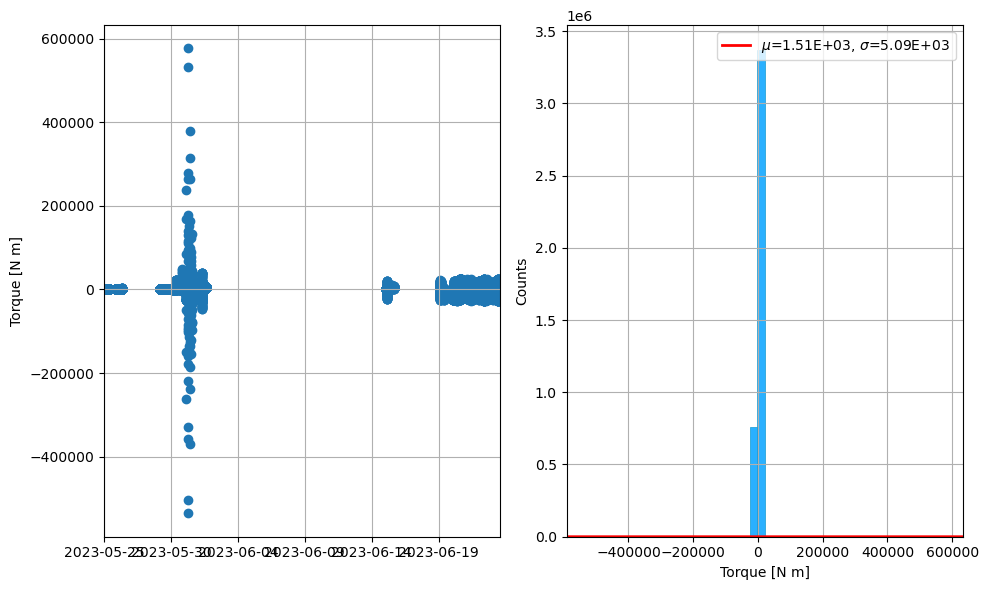

In [26]:
%matplotlib inline
figure_name = "balancing_m1m3surr_May23_Aug23"

fig, axs = plt.subplots(1, 2, figsize=[10, 6], num=figure_name)
axs[0].scatter(all_data_az.index, all_data_az)
axs[0].set_ylabel("Torque [N m]")
axs[0].set_xticks(
    np.arange(
        np.min(all_data_az.index.tz_localize(None)),
        np.max(all_data_az.index.tz_localize(None)),
        step=np.timedelta64(5, "D"),
    )
)
axs[0].set_xlim(
    np.min(all_data_az.index.tz_localize(None)),
    np.max(all_data_az.index.tz_localize(None)),
)

axs[1].hist(
    all_data_az["actualTorque"],
    bins=50,
    facecolor="#2ab0ff",
    edgecolor="#169acf",
    linewidth=0.5,
)

mu, std, p, x, xmin, xmax = fitGaussian(all_data_az["actualTorque"], axs[1])

axs[1].plot(
    x,
    p,
    label="$\mu$={:.2E}, $\sigma$={:.2E}".format(mu, std),
    linewidth=2,
    color="red",
)
axs[1].set_ylabel("Counts")
axs[1].set_xlabel("Torque [N m]")
axs[1].legend()
axs[1].set_xlim(xmin, xmax)

for ax in axs:
    ax.grid()

fig.tight_layout()
fig.savefig(f"{figure_dir}/{figure_name}.jpg", dpi=200)

plt.show()

# showAndClear()

## M1M3 Surrogate and Cell, M2 Surrogate and Cell on the TMA - Nov 2023 to Jan 2024

In [ ]:
startPoint = np.datetime64("2023-11-01T12:00:00")
endPoint = np.datetime64("2024-01-01T12:00:00")
starts, ends = makeDateRange(startPoint, endPoint)

In [ ]:
all_data = await getDataFrame(client,starts,ends,topic,fields=fields,verbose=False)

In [ ]:
lolim,uplim = pd.Timestamp("2023-11-14").tz_localize("UTC"),pd.Timestamp("2023-11-25").tz_localize("UTC")
limited_data = all_data.loc[lolim:uplim]

In [ ]:
fig,axs = plt.subplots(2,1,figsize=[10,6],sharex=True)
for ax in axs:
    ax.plot(limited_data.index,limited_data)
    ax.set_ylabel("Torque [N m]")
    ax.set_xticks(np.arange(lolim,uplim,step=np.timedelta64(1,"D")))
    ax.set_xlim(lolim,uplim)
    ax.grid()
axs[0].set_ylim(-0.4E5,0.4E5)
axs[1].set_ylim(-0.8E4,0.8E4)
axs[1].set_xlabel("Date")
showAndClear()

## M2 Surrogate and Cell on the TMA - Feb to Apr 2024

In [ ]:
startPoint = np.datetime64("2024-02-01T12:00:00")
endPoint = np.datetime64("2024-04-01T12:00:00")
starts, ends = makeDateRange(startPoint, endPoint)

In [ ]:
all_data = await getDataFrame(client,starts,ends,topic,fields=fields,verbose=False)

In [ ]:
lolim,uplim = pd.Timestamp("2024-02-05").tz_localize("UTC"),pd.Timestamp("2024-02-15").tz_localize("UTC")
limited_data = all_data.loc[lolim:uplim]

In [ ]:
fig,axs = plt.subplots(2,1,figsize=[10,6],sharex=True)
for ax in axs:
    ax.plot(limited_data.index,limited_data)
    ax.set_ylabel("Torque [N m]")
    ax.set_xticks(np.arange(lolim,uplim,step=np.timedelta64(2,"D")))
    ax.set_xlim(lolim,uplim)
    ax.grid()
axs[0].set_ylim(-2E5,2E5)
axs[1].set_ylim(-0.8E2,0.8E2)
axs[1].set_xlabel("Date")
showAndClear()